In [1]:
import os
import sys
import pprint

base_dir = 'C:\Documents\Thesis_ssd\MasterThesis'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.BaselineHelperFunctions import BaselineHelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter
from Classes.Modeling.GridSearchResultProcessor import GridSearchResultProcessor
import json

helper = BaselineHelperFunctions()
%load_ext tensorboard

In [2]:
num_classes = 2
loadData = LoadData(num_classes, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
handler = DataHandler()
pp = pprint.PrettyPrinter(indent=4)
helper = BaselineHelperFunctions()

In [3]:
hyper_grid = {
        "batch_size" : [32, 64, 128, 256, 512],
        "epochs" : [1],
        "learning_rate" : [0.1, 0.01, 0.001, 0.0001, 0.00001],
        "optimizer" : ["adam", "rmsprop", "sgd"]
    }
model_grid = {
    "activation" : ["relu", "sigmoid", "softmax", "tanh"],
    "dropout_rate" : [0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0],
    "filters" : [11, 13, 15, 17, 19, 21, 23, 25],
    "kernel_size" : [3, 5, 7, 9, 11, 13],
    "l1_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "l2_r" : [0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
    "output_layer_activation" : ["softmax", "sigmoid"],
    "padding" : ["same"],
    "start_neurons" : [8,16, 32, 64, 128, 256, 512]
}
"""
{'activation': 'softmax', 
 'dropout_rate': 0.1, 
 'filters': 25, 
 'kernel_size': 9, 
 'l1_r': 0.01, 
 'l2_r': 0.0001, 
 'output_layer_activation': 'softmax', 
 'padding': 'same', 
 'start_neurons': 32}
"""


model_nr = 8

test_mode = True
use_scaler = False
use_noise_augmentor = False
detrend = False
use_minmax = False
use_highpass = True
highpass_freq = 0.1

n_picks = 1

use_tensorboard = False
use_liveplots = False
use_custom_callback = False
use_early_stopping = True
start_from_scratch = False

In [4]:
randomGridSearch = RandomGridSearch(train_ds, val_ds, test_ds, model_nr, test_mode, detrend,
                                    use_scaler, use_noise_augmentor, use_minmax, use_highpass, n_picks, 
                                    hyper_grid = hyper_grid, model_grid = model_grid, 
                                    num_classes = num_classes, use_tensorboard = use_tensorboard,
                                    use_liveplots = use_liveplots, use_custom_callback = use_custom_callback,
                                    use_early_stopping = use_early_stopping, highpass_freq = highpass_freq,
                                    start_from_scratch = start_from_scratch)

In [5]:
results, highest_test_accuracy_index, highest_train_accuracy_index, highest_test_precision_index, highest_test_recall_index= randomGridSearch.fit()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (512, 3, 8)               192320    
_________________________________________________________________
dropout (Dropout)            (512, 3, 8)               0         
_________________________________________________________________
batch_normalization (BatchNo (512, 3, 8)               32        
_________________________________________________________________
lstm_1 (LSTM)                (512, 3, 4)               208       
_________________________________________________________________
dropout_1 (Dropout)          (512, 3, 4)               0         
_________________________________________________________________
batch_normalization_1 (Batch (512, 3, 4)               16        
_________________________________________________________________
dense (Dense)                (512, 3, 2)               1

In [6]:
results_df = randomGridSearch.results_df.copy()

In [7]:
results_df[results_df.columns[0:13]]

,batch_size,epochs,learning_rate,optimizer,activation,dropout_rate,filters,kernel_size,l1_r,l2_r,output_layer_activation,padding,start_neurons
0,512,1,1e-05,sgd,relu,0.5,23,9,0.2,0.001,sigmoid,same,8


In [8]:
results_df[results_df.columns[13:]]

,train_loss,train_accuracy,train_precision,train_recall,val_loss,val_accuracy,val_precision,val_recall
0,650.678955,0.529297,0.515284,0.345703,3257.462158,0.511719,0.53022,0.376953


In [9]:
min_loss, max_accuracy, max_precision, max_recall = randomGridSearch.find_best_performers(results_df)

In [10]:
min_loss_i = min_loss['val_index']
max_acc_i = max_accuracy['val_index']
max_prec_i = max_precision['val_index']
max_recall_i = max_recall['val_index']

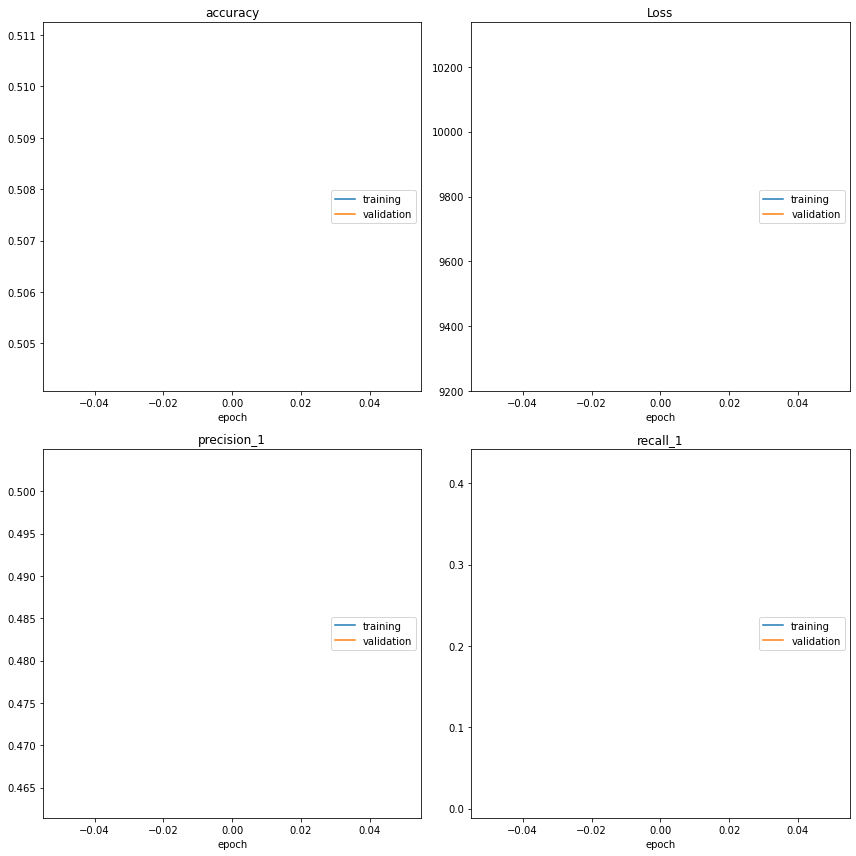

accuracy
	training         	 (min:    0.511, max:    0.511, cur:    0.511)
	validation       	 (min:    0.504, max:    0.504, cur:    0.504)
Loss
	training         	 (min: 10285.473, max: 10285.473, cur: 10285.473)
	validation       	 (min: 9251.080, max: 9251.080, cur: 9251.080)
precision_1
	training         	 (min:    0.503, max:    0.503, cur:    0.503)
	validation       	 (min:    0.463, max:    0.463, cur:    0.463)
recall_1
	training         	 (min:    0.422, max:    0.422, cur:    0.422)
	validation       	 (min:    0.009, max:    0.009, cur:    0.009)
22/21 [==============================] - 18s 825ms/step - loss: 10285.4727 - accuracy: 0.5109 - precision_1: 0.5030 - recall_1: 0.4217 - val_loss: 9251.0801 - val_accuracy: 0.5044 - val_precision_1: 0.4634 - val_recall_1: 0.0093
Instructions for updating:
Please use Model.predict, which supports generators.
[[ 17 403]
 [ 14 389]]


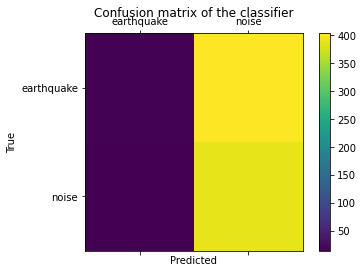

Test loss: 15293.0537109375
Test accuracy: 0.5068359375
Test precision: 0.523809552192688
Test recall: 0.0107421875


In [11]:
min_loss_model = randomGridSearch.fit_from_index(results_df, min_loss_i)

In [12]:
fit_from_index(results_df, 0)

NameError: name 'fit_from_index' is not defined

In [ ]:
build_model_args = self.helper.generate_build_model_args(self.model_nr, batch_size, dropout_rate, 
                                                                     activation, output_layer_activation,
                                                                     l2_r, l1_r, start_neurons, filters, kernel_size, 
                                                                     padding, self.num_classes)

In [ ]:
randomGridSearch.find_best_performers(loaded_result)

In [ ]:
def find_best_performers(results_df):
    train_loss_index = results_df.columns.get_loc('train_loss')
    metrics = results_df[results_df.columns[train_loss_index:]]
    min_loss = {'train_loss' : min(metrics['train_loss']), 'val_loss' : min(metrics['val_loss']), 
                'train_index' : metrics_df[metrics_df['train_loss'] == min(metrics_df['train_loss'])].index[0], 
                'val_index' : metrics_df[metrics_df['val_loss'] == min(metrics_df['val_loss'])].index[0]}
    
    max_accuracy = {'train_accuracy' : max(metrics['train_accuracy']), 'val_accuracy' : max(metrics['val_accuracy']), 
                    'train_index' : metrics_df[metrics_df['train_accuracy'] == max(metrics_df['train_accuracy'])].index[0], 
                    'val_index' : metrics_df[metrics_df['val_accuracy'] == max(metrics_df['val_accuracy'])].index[0]}
    
    max_precision = {'train_precision' : max(metrics['train_precision']), 'val_precision' : max(metrics['val_precision']), 
                     'train_index' : metrics_df[metrics_df['train_precision'] == max(metrics_df['train_precision'])].index[0], 
                     'val_index' : metrics_df[metrics_df['val_precision'] == max(metrics_df['val_precision'])].index[0]}
    
    max_recall = {'train_recall' : max(metrics['train_recall']), 'val_recall' : max(metrics['train_recall']), 
                  'train_index' : metrics_df[metrics_df['train_recall'] == max(metrics_df['train_recall'])].index[0], 
                  'val_index' : metrics_df[metrics_df['val_recall'] == max(metrics_df['val_recall'])].index[0]}
    
    return min_loss, max_accuracy, max_precision, max_recall
    

In [ ]:
find_best_performers(results_df)

In [ ]:
results_df

In [ ]:
print(keys)
print(keys2)

In [ ]:
keys[0]

In [ ]:
import numpy as np
import pandas as pd
hyper_keys = list(hyper_grid.keys())
model_keys = list(model_grid.keys())
metrics_train_keys = ["train_loss", "train_accuracy", "train_presicion", "train_recall"]
metrics_val_keys = ["val_loss", "val_accuracy", "val_presicion", "val_recall"]
header = np.concatenate((hyper_keys, model_keys, metrics_train_keys, metrics_val_keys))
info_table = pd.DataFrame(np.array([i for i in range(len(header))]).reshape(1, 21) ,columns = header)

In [ ]:
info_table

In [ ]:
testing = pd.DataFrame([[0, np.nan]], columns = ["a", "b"])

In [ ]:
to_add = pd.DataFrame(np.array([0 ,1]).reshape(1,2), columns = ["a", "b"])
print(to_add)
testing = testing.append(to_add)
testing

In [ ]:
nan_columns = testing.columns[testing.isnull().any()].tolist()

In [ ]:
temp_df

In [ ]:
nan_columns = temp_df.columns[temp_df.isna().any()].tolist()

In [ ]:
nan_cols = [i for i in temp_df.columns if pd.isnull(temp_df[i].values)]

In [ ]:
for column in temp_df.columns:
    print(temp_df[column].values)

In [ ]:
temp_df['val_loss'].dtype